In [ ]:
!apt install libgraphviz-dev
!pip install pygraphviz
!pip install netgraph

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 23 not upgraded.
Need to get 2,148 kB of archives.
After this operation, 7,427 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/main amd64 libgtk2.0-common all 2.24.32-4ubuntu4 [126 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/main amd64 libgtk2.0-0 amd64 2.24.32-4ubuntu4 [1,791 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/main amd64 libgail18 amd64 2.24.32-4ubuntu4 [14.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/main amd64 libgail-common amd64 2.24.32-4ub

In [44]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from netgraph import Graph

# Mini Project

## Get Dataset

In [ ]:
!wget --no-check-certificate https://deim.urv.cat/~alexandre.arenas/data/xarxes/jazz.zip -O jazz.zip
!wget https://web.archive.org/web/20041023052543fw_/http://www.ffn.ub.es/~gleiser/musicians_names.net -O musician_names.net
!unzip -o jazz.zip

--2023-03-22 01:18:09--  https://deim.urv.cat/~alexandre.arenas/data/xarxes/jazz.zip
Resolving deim.urv.cat (deim.urv.cat)... 84.88.201.135
Connecting to deim.urv.cat (deim.urv.cat)|84.88.201.135|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 15283 (15K) [application/zip]
Saving to: ‘jazz.zip’

jazz.zip            100%[===================>]  14.92K  --.-KB/s    in 0.1s    

2023-03-22 01:18:10 (106 KB/s) - ‘jazz.zip’ saved [15283/15283]

--2023-03-22 01:18:10--  https://web.archive.org/web/20041023052543fw_/http://www.ffn.ub.es/~gleiser/musicians_names.net
Resolving web.archive.org (web.archive.org)... 207.241.237.3
Connecting to web.archive.org (web.archive.org)|207.241.237.3|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://web.archive.org/sry [following]
--2023-03-22 01:18:10--  https://web.archive.org/sry
Reusing existing connection to web.archive.org:443.


In [ ]:
# Convert to edgelist
edgelist= []
with open('jazz.net') as f:
    for i, line in enumerate(f):
        if i < 3: continue
        line = " ".join(line.strip().split())
        edgelist.append(tuple([int(v) for v in line.split()[:-1]]))

In [ ]:
edgelist[:10]

[(1, 8),
 (1, 24),
 (1, 35),
 (1, 42),
 (1, 46),
 (1, 60),
 (1, 74),
 (1, 78),
 (1, 81),
 (1, 95)]

## Load Network

In [ ]:
G_bands = nx.Graph()
G_bands.add_edges_from(edgelist)

In [ ]:
print("Nodes:", G_bands.number_of_nodes())
print("Edges", G_bands.number_of_edges())

Nodes: 198
Edges 2742


In [ ]:
degrees_node = sorted([i for i in G_bands.degree()])
degrees = [i[1] for i in degrees_node]
nodesize = [i[1]*5 for i in degrees_node]

vmin = min(degrees)
vmax = max(degrees)

We display the network, styling the node colours and sizes according to its degree.

<ipython-input-11-040426c31374>:11: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


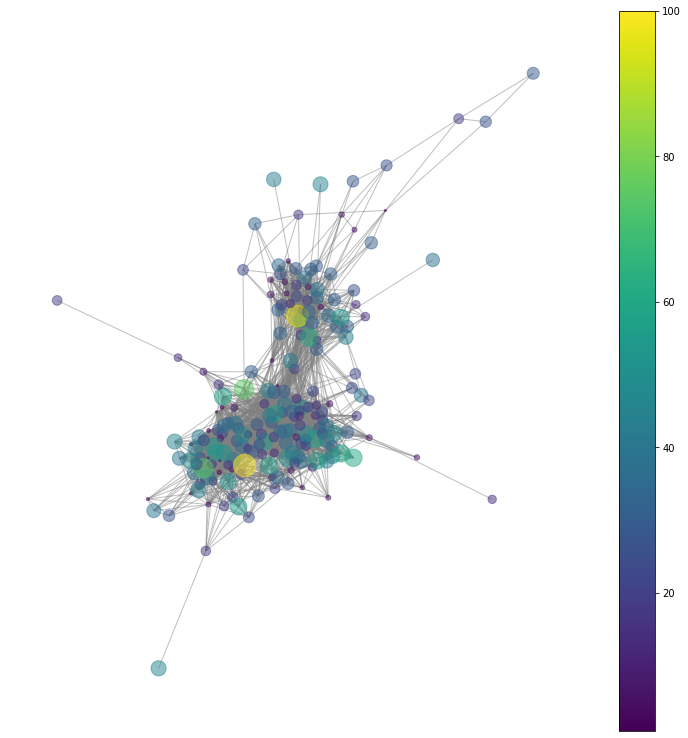

In [ ]:
plt.figure(figsize=(10,10))
settings = {
    'node_size':nodesize,
    'alpha': 0.5,
    'edge_color': 'grey',
    'cmap': 'viridis',
    'node_color': degrees, 
}
nx.draw_spring(G_bands, **settings)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.colorbar(sm)

## Initial Analysis

### Cummulative Deg Distribution
Generate the cummulative degree distribution of the degree of the nodes in the network.

In [ ]:
n_nodes = G_bands.number_of_nodes()
deg, cnt = np.unique(degrees, return_counts=True)
cnt_cum = np.flip(np.cumsum(np.flip(cnt)))

cummulative_deg_dist = [c/n_nodes for c in cnt_cum]

In [ ]:
def exponential_curve(k, k_, ab):
    return np.exp(-(k/k_)**ab)

curve_fit(exponential_curve, deg, cummulative_deg_dist)

(array([32.00325641,  1.70987947]), array([[ 0.02546286, -0.00013297],
        [-0.00013297,  0.00049979]]))

As we can see the results for the fit are quite similar to what the authors reported ($k*=32.8$ and $a_b=1.78$)

In [ ]:
x_fit = np.arange(0, 101)
y_fit = np.apply_along_axis(
    lambda x:exponential_curve(x, 32.00325641,  1.70987947), 
    0, x_fit
)

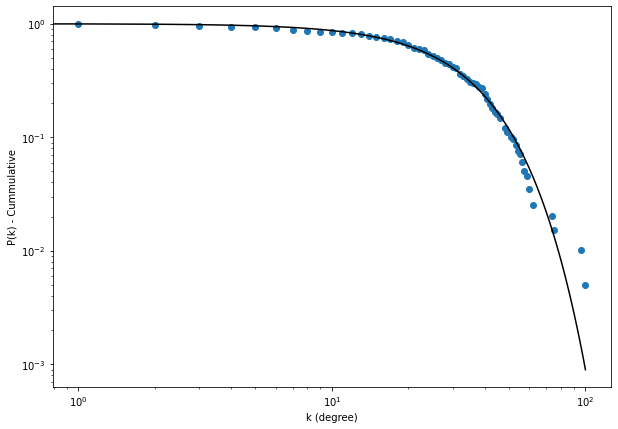

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(deg, cummulative_deg_dist)
plt.plot(x_fit, y_fit, c='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('k (degree)')
plt.ylabel('P(k) - Cummulative')
plt.show()

## Community Structures

In [ ]:
import itertools
from tqdm import tqdm
from networkx.algorithms.community.centrality import girvan_newman

In [ ]:
communities = girvan_newman(G_bands)

In [ ]:
level = []
for com in tqdm(communities):
    level.append(list(com))

197it [03:53,  1.18s/it]


We use the concept of modularity to define our cutpoint or threshold when removing links. Modularity gives us a way of measure the density of connections within each community vs the sparseness of connections among communties. (like a internal/external metric).

In [ ]:
# Calculate modularity
n_communities, modularity = [], []
max_n_comm, max_modularity, max_i = 0, 0, 0
for i, l in enumerate(level):
    #print(f"{i}:",[len(c) for c in l])
    n_comm = len(l)
    mod = nx.algorithms.community.modularity(G_bands, l)
    n_communities.append(n_comm)
    modularity.append(mod)
    if mod > max_modularity:
        max_modularity, max_n_comm, max_i = mod, n_comm, i

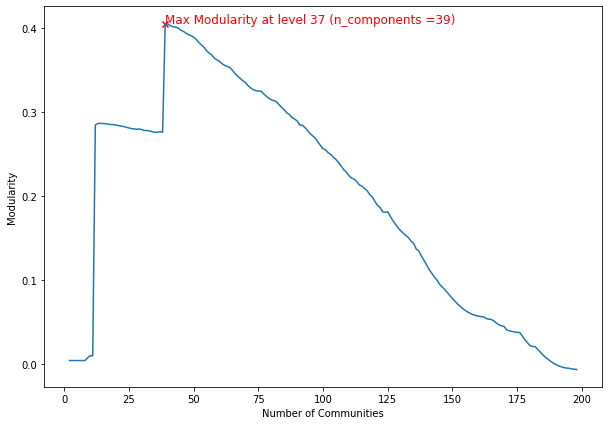

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(n_communities, modularity)
plt.scatter([max_n_comm], [max_modularity], c='r', marker='x')
plt.text(max_n_comm, max_modularity,
    s=f"Max Modularity at level {max_i} (n_components ={max_n_comm})",
    c='r',
    fontsize=12
)
plt.xlabel('Number of Communities')
plt.ylabel('Modularity')
plt.show()

For this threshold we analyze the community sizes:

In [ ]:
community_clusters = level[37]
community_clusters.sort(key=len, reverse=True)

print("N_communities:", len(community_clusters))
print("Modularity =", max_modularity)
print("---------------------------")
print("Top 10 communities by size:")
print(f"{'ID':<15} comm_size")
for i, c in enumerate(community_clusters[:10]):
    print(f"{i:<16}{len(c)}")

N_communities: 39
Modularity = 0.4050988992046884
---------------------------
Top 10 communities by size:
ID              comm_size
0               59
1               49
2               45
3               4
4               4
5               3
6               2
7               1
8               1
9               1


Here we can see that we have built 3 large communities, and the rest of the 39 communities are small. This is can be seen on the original network:

In [ ]:
# Give colors to the top 5 communities, the rest of nodes become grey
colors = ['#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600']

color_map = []
for node in G_bands:
    assigned_color = 'grey'
    for i, color in enumerate(colors):
        if node in community_clusters[i]:
            assigned_color = color
            break
    color_map.append(assigned_color)
degrees_node = sorted([i for i in G_bands.degree()])
degrees = [i[1] for i in degrees_node]
nodesize = [i[1]*5 for i in degrees_node]

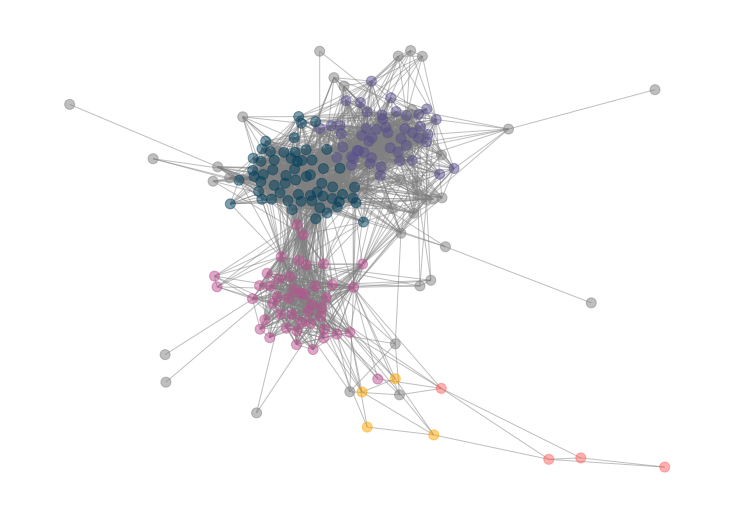

In [ ]:
plt.figure(figsize=(10,7))
settings = {
    'node_size':100,
    'alpha': 0.5,
    'edge_color': 'grey',
    'node_color': color_map,
}

nx.draw(G_bands, **settings)

We have 3-4 large communities and the rest of the nodes (depicted in grey) are alone.

### Construction of Community Segmentation Tree

To replicate the results from the article and display the communities, we use the same representation based on the "dendogram" (or binary tree) that emerges when performing the splits using Girvan-Newman.

The code below reconstructs the graph from the communities lists generated by networkx:

In [ ]:
level_list = [[list(c) for c in l] for l in level]

# Build binary tree with level list
G_tree = nx.Graph()

# Initialize
root = "G0"
t_id = 1
edges = []
prev_level_bynode = {}
for cluster in level_list[0]:
    if len(cluster) <= 1:
        if root == cluster[0]: continue
        edges.append((root, cluster[0]))
        prev_level_bynode[cluster[0]] = cluster
        continue
    edges.append((root, f"G{t_id}"))
    prev_level_bynode[f"G{t_id}"] = cluster
    t_id+=1
G_tree.add_edges_from(edges)


for l in tqdm(level_list[1:]):
    edges = []
    new_prev_level_bynode = {}
    for cluster in l:
        for root in prev_level_bynode:
            prev_cluster = prev_level_bynode[root]
            if set(cluster).issubset(set(prev_cluster)):
                if len(cluster) <= 1:
                    if root == cluster[0]: continue
                    edges.append((root, cluster[0]))
                    new_prev_level_bynode[cluster[0]] = cluster
                    continue
                if set(cluster) == set(prev_cluster):
                    new_prev_level_bynode[root] = cluster
                else:
                    new_prev_level_bynode[f"G{t_id}"] = cluster
                    edges.append((root, f"G{t_id}"))
                    t_id += 1
    G_tree.add_edges_from(edges)
    prev_level_bynode = new_prev_level_bynode

print("Is Tree?", nx.is_tree(G_tree))

100%|██████████| 196/196 [00:00<00:00, 1731.15it/s]

Is Tree? True


As specified by the authors, on each split within the tree it means that an edge within the graph was removed, resulting in a new division

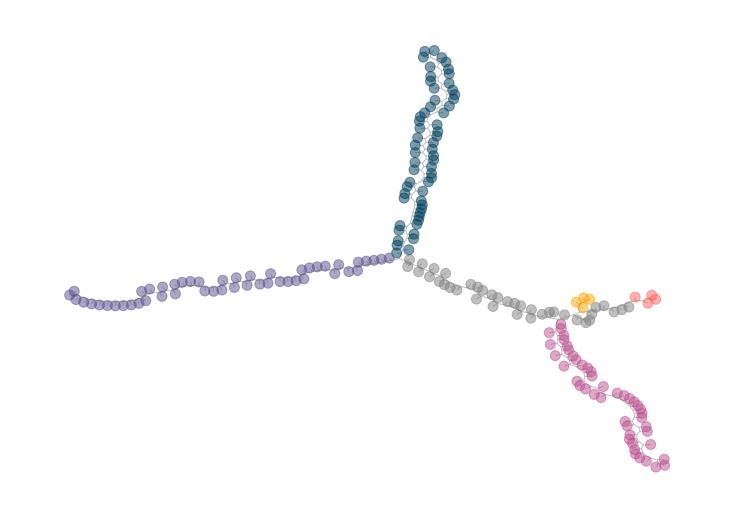

In [ ]:
community_clusters = level[37]
community_clusters.sort(key=len, reverse=True)

tree_color_map = []
tree_node_size = []
for node in G_tree:
    if type(node) is int:
        assigned_color = 'grey'
        for i, color in enumerate(colors):
            if node in community_clusters[i]:
                assigned_color = color
                break
        tree_color_map.append(assigned_color)
        tree_node_size.append(100)
    else:
        tree_color_map.append('black')
        tree_node_size.append(0)

plt.figure(figsize=(10,7))
settings = {
    'node_size':tree_node_size,
    'alpha': 0.5,
    'edge_color': 'grey',
    'node_color': tree_color_map,
    'pos': nx.nx_agraph.graphviz_layout(G_tree, prog="neato", root="G0")
}

nx.draw(G_tree, **settings)

### Community size distribution

Finally we analyze the behaviour of the community sizes:

In [ ]:
level_comm_sizes = [[len(c) for c in l] for l in level]
all_sizes = [s for l in level_comm_sizes for s in l]
sizes, cnt = np.unique(all_sizes, return_counts=True)
cnt_cum = np.flip(np.cumsum(np.flip(cnt)))
P_s = cnt_cum / np.sum(cnt)

In [ ]:
m = -0.48
x = np.array([1, 200])
y = x**m 

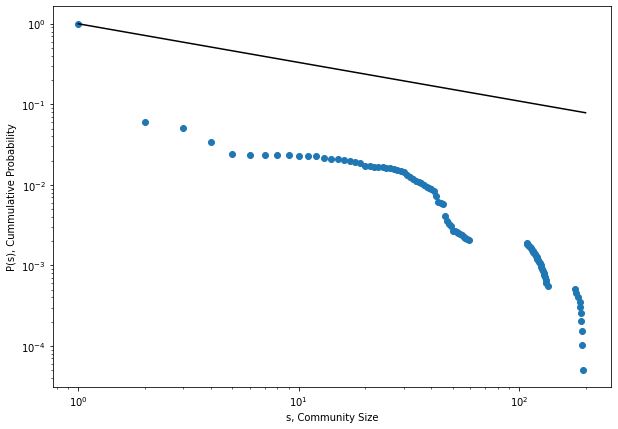

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(sizes, P_s)
plt.plot(x, y, c='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('s, Community Size')
plt.ylabel('P(s), Cummulative Probability')
plt.show()